In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import ruptures as rpt
import warnings
import matplotlib as mpl
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [18, 10]
plt.style.use('ggplot')
mpl.rcParams['axes.color_cycle'] = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854'] #from http://colorbrewer2.org

In [19]:
#https://www.openml.org/d/531
data = pd.read_csv('boston.csv')
#Wszystkie zmienne są liczbowe

In [20]:
X_data, y_data = data.drop(['MEDV'], axis=1), data['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data)

### Modele wytrenowane na surowych danych 

In [21]:
model_1 = RandomForestRegressor(n_estimators=200)
model_1.fit(X_train, y_train)

model_2 = CatBoostRegressor(silent=True)
model_2.fit(X_train, y_train)

model_3 = LinearRegression()
model_3.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Obliczanie MSE każdego z nich

In [22]:
ypred_1 = model_1.predict(X_test)
mse_1 = mean_squared_error(ypred_1, y_test)

ypred_2 = model_2.predict(X_test)
mse_2 = mean_squared_error(ypred_2, y_test)

ypred_3 = model_3.predict(X_test)
mse_3 = mean_squared_error(ypred_3, y_test)

In [23]:
mse_1, mse_2, mse_3

(8.457442659448818, 11.992288294433814, 24.035018038812836)

#### Z modeli RandomForest i CatBoost MSE jest niższe dla RandomForest, dlatego ALE wybrano z tego modelu

#### Pomocnicza funkcja do obliczania ALE  

In [24]:
def ale_func(X_data, model, chosen_feature, bins):
    data_inner = X_data.copy()
    data_inner['range_left'] = pd.cut(X_data[chosen_feature], bins).apply(lambda x: x.left).astype(float)
    data_inner['range_right'] = pd.cut(X_data[chosen_feature], bins).apply(lambda x: x.right).astype(float)
    
    lower_limit = data_inner.copy()
    lower_limit[chosen_feature] = lower_limit['range_left']
    higher_limit = data_inner.copy()
    higher_limit[chosen_feature] = higher_limit['range_right']
    
    lower_limit['target'] = model.predict(lower_limit.drop(['range_left', 'range_right'], axis=1))
    higher_limit['target'] = model.predict(higher_limit.drop(['range_left', 'range_right'], axis=1))
    
    higher_limit['diff'] = higher_limit['target'] - lower_limit['target']
    higher_limit['x_diff'] = (higher_limit['range_right'] + lower_limit['range_left'])/2
    values = higher_limit.groupby(['range_right']).mean()
    return (values['x_diff'].ravel(), np.cumsum(values['diff']).ravel())


#### Pomocnicza funkcja do obliczania przedziałów

In [25]:
def plot_ale_with_cuts(model, X_train, transforming_feature):
    bins=20
    x, signal = ale_func(X_train, model_1, 'AGE', bins=bins)
    plt.plot(x, signal, color='#8da0cb',)
    algo = rpt.Pelt(model="l1").fit(signal)
    result = algo.predict(pen=0.3)
    cuts = []
    for i in range(len(result)-1):
        cut = (x[result[i]-1] + x[result[i]])/2
        cuts.append(cut)
        plt.axvline(cut, color='#fc8d62', linestyle = "--")
    plt.xlabel(transforming_feature, fontsize=18)
    plt.ylabel('ALE', fontsize=18)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.show()
    return [-np.inf] + cuts + [np.inf]

#### ALE dla zmiennej AGE wraz z narysowanymi przedziałami

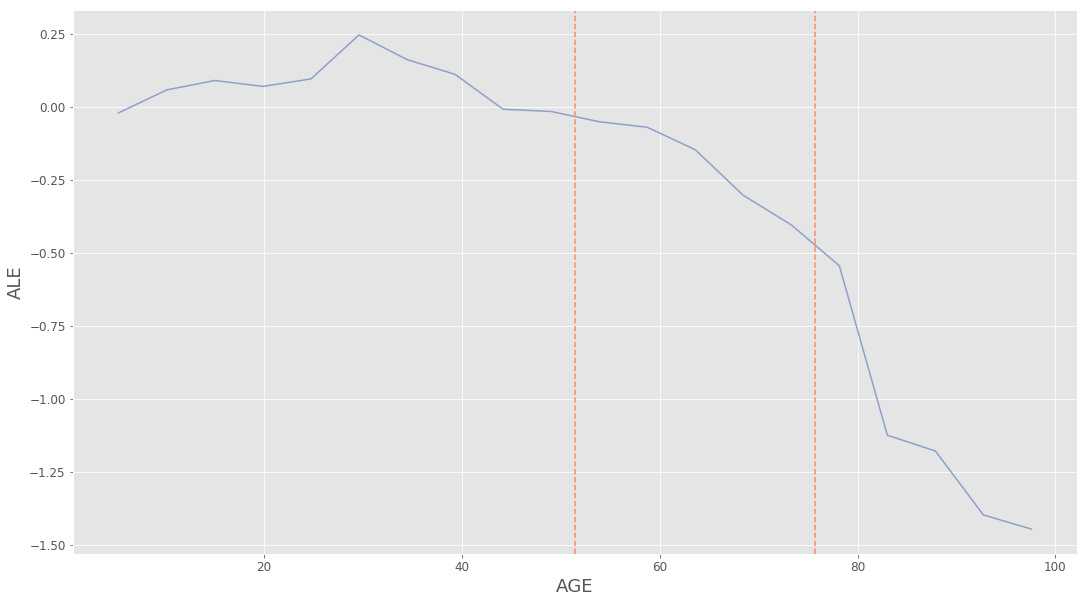

In [26]:
cuts = plot_ale_with_cuts(model_1, X_train, 'AGE')

#### Tranformacja danych do kategorycznych

In [27]:
def tranform_feature(data, feature, cuts):
    data[feature+"_range"] = pd.cut(data[feature], cuts)
    data = pd.get_dummies(data, columns=[feature+"_range"])
    return data

In [28]:
X_train = tranform_feature(data=X_train, feature='AGE', cuts=cuts)
X_test = tranform_feature(data=X_test, feature='AGE', cuts=cuts)

#### Nowe modele na podstawie rozszerzonych danych

In [29]:
model_4 = RandomForestRegressor(n_estimators=200)
model_4.fit(X_train, y_train)

model_5 = CatBoostRegressor(silent=True)
model_5.fit(X_train, y_train)

model_6 = LinearRegression()
model_6.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
ypred_4 = model_4.predict(X_test)
mse_4 = mean_squared_error(ypred_4, y_test)

ypred_5 = model_5.predict(X_test)
mse_5 = mean_squared_error(ypred_5, y_test)

ypred_6 = model_6.predict(X_test)
mse_6 = mean_squared_error(ypred_6, y_test)

#### Tworzenie tabeli z porównaniami modeli

In [31]:
data = pd.DataFrame({
    "model": ["RandomForest", "CatBoost", "LinearRegression", "RandomForest", "CatBoost", "LinearRegression"],
    "type": ["original", "original", "original",  "transformed",  "transformed", "transformed"],
    "mse": [mse_1, mse_2, mse_3, mse_4, mse_5, mse_6]
})

In [32]:
data

,model,type,mse
0,RandomForest,original,8.457443
1,CatBoost,original,11.992288
2,LinearRegression,original,24.035018
3,RandomForest,transformed,8.864721
4,CatBoost,transformed,10.852514
5,LinearRegression,transformed,24.285086


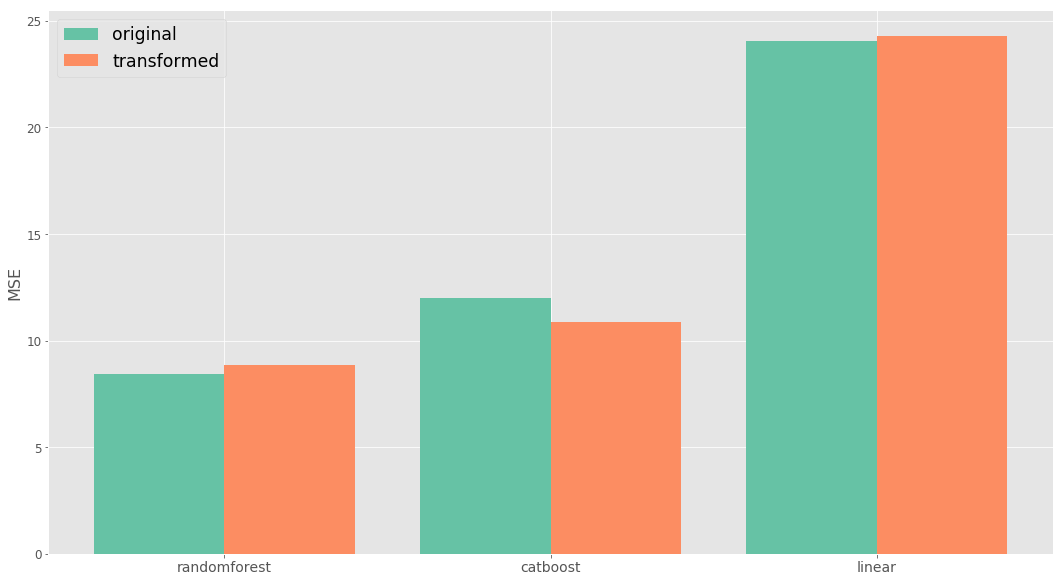

In [33]:
plt.bar(np.arange(3)-0.2, data['mse'].loc[data['type'] == 'original'],width=0.4, label='original')
plt.bar(np.arange(3)+0.2, data['mse'].loc[data['type'] == 'transformed'],width=0.4, label='transformed')
plt.xticks(np.arange(3), 
           ['randomforest', 'catboost', 'linear'], fontsize=14)
plt.yticks(fontsize=12)
plt.legend(fontsize='xx-large')
plt.ylabel('MSE', fontsize=16)
plt.show()

### Wnioski
#### Dla randomforest i linear użycie zgrupowanych danych nie poprawiło modeli, natomiast poprawiło model catboost.
#### Wykorzystano tutaj podział z randomforest, który był lepszy na początku analizy, ale nie potrafił się po transformacjach..